In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import tracktor_extension as trx
import cv2
import sys
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# t_id is termite id and is also used for individual identification
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in t_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 20
t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'Z']

colours = trx.get_spaced_colors(n_inds)

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 0.2

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = trx.round_up_to_odd(61*scaling)
offset = 60

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = int(5*scaling)
max_area = int(500*scaling)

# in this example, we use a circular mask to ignore area outside the petri-dish
# mask_offset represents offset of circle from centre of the frame
#circle_radius sets radius, colour_ignored_area sets area outside of roi to black (0) or white (255)
mask_offset_x = 2
mask_offset_y = -15
circle_radius = int(697*scaling)
colour_ignored_area = 255

#do you want to click on the initial positions in the first frame?
mouse_input = False

# limits how often the algorithm iteratively erodes/dilates the thresholded image, slows down algorithm.
# Can be useful to separate merged contours or merge separated fragments of the same contour
ero_dil_limit = 5

# If more than one object is tracked, different strategies are available to try keeping identities. 
# Algorithms in methods1 trie to identify the object in the last frame (or the kalman estimate of the current frame),
# which was lost in the current frame. Set methods1 to 'distance', which will consider objects as lost,
# if they are far away from objects in the current frame. This is fast but is prone to detecting
# fast objects as lost. Set methods1 to 'hungarian', which will consider objects lost, 
# by iteratively applying the hungarian algorithm and finding the objects which fit worst to objects 
# in the current frame. Slower than 'distance'.
# Based on the objects identified as lost, methods2 will try to make statements about their current position. 
# Setting to 'keep' will carry over the positions of the lost points to the current frame. 
# 'next contour' will find the closest contour to the lost objects and keeps a copy of them in the current frame. 
# The default 'kmeans' will enable k-means clustering to force n_inds number of animals. 
# Slower than 'keep' or 'next_contour' down algorithm.
# Setting either to '' will omit this step.
methods1 = 'distance'
methods2 = 'next_contour'

#If kalman is set to True, the algorithm tries to infer the positions of the current frame by using a simple kalman
# estimate on the positions of the last frame and subsequently uses the estimates instead of the positions in the
# last frame
kalman = True

# name of source video and paths
video = 'test'
input_vidpath = 'C:/Users/jahn_/Documents/Python Scripts/tracktor-master/videos/' + video + '.mp4'
output_vidpath = 'C:/Users/jahn_/Documents/Python Scripts/tracktor-master/output/' + video + '_tracked1.mp4'
output_filepath = 'C:/Users/jahn_/Documents/Python Scripts/tracktor-master/output/' + video + '_tracked1.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

In [4]:
## Open video
cap = cv2.VideoCapture(str(input_vidpath))
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(np.ceil(cap.read()[1].shape[1]*scaling)),int(np.ceil(cap.read()[1].shape[0]*scaling)))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

df = []
last = 0
lost_count = 0
frame_count = 0

#initial variables for the simple kalman estimate
R = 0.01**2
kl_Ps = np.zeros([n_inds, 4,4])
for i in np.arange(0,n_inds,1):
    kl_Ps[i] = np.matrix(np.eye(4))*1000 # initial uncertainty
kl_estimate = np.zeros([n_inds, 2])
kl_velocities = np.zeros([n_inds, 2])


while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    ero_dil_count = 0
    
    this = cap.get(1)
    if ret == True:
        # Preprocess the image for background subtraction
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        
        # Apply mask to ignore area outside circle
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        cv2.circle(mask, (mask.shape[1]//2 + mask_offset_x, mask.shape[0]//2 + mask_offset_y), circle_radius, 255, -1)
        frame[mask == 0] = colour_ignored_area
        
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        # Custom background subtraction
        bg = thresh.copy()
        cv2.circle(bg, (bg.shape[1]//2 + mask_offset_x, bg.shape[0]//2 + mask_offset_y), 780, 0, -1)
        bgsub = thresh - bg
        
        #take user input for initial object positions
        if frame_count == 0 and mouse_input == True:
            meas_last, kl_estimate = trx.mouse_input(frame, n_inds, meas_last)
        else:
            final, contours, meas_last, meas_now = trx.detect_and_draw_contours(frame, thresh, meas_last, meas_now, ero_dil_count, min_area, max_area)
        
            
        #simple kalman estimate
        if kalman == True:
            kl_estimate, kl_velocities, kl_Ps = trx.apply_simple_kalman(R, n_inds, kl_velocities, kl_Ps, kl_estimate, meas_last)
            meas_last = kl_estimate
            
        #use dilation and erosion until limit is exceeded or enough contours are found
        final, contours, meas_now = trx.apply_dilation_and_erosion(mask, final, contours, frame, thresh, meas_now, meas_last, n_inds, ero_dil_limit, ero_dil_count, min_area, max_area)
            
        if len(meas_now) != n_inds: #if detected contours still dont match try to assign positions in current frame with different strategies
            lost_count += 1
            #get putative_lost_points
            if methods1 == 'distance':
                lost_points = trx.find_lost_points1(meas_last, meas_now, n_inds)
            elif methods1 == 'hungarian':
                lost_points = trx.find_lost_points2(meas_last, meas_now, n_inds)
            elif methods1 == '':
                pass
            
            #use putative_lost_points to fill in values in meas_now up to n_inds
            if methods2 == 'keep':
                meas_now = trx.assign_lost_points1(meas_now, lost_points)
            elif methods2 == 'next_contour':
                meas_now = trx.assign_lost_points1(meas_now, lost_points)
            elif methods2 == 'kmeans':
                contours, meas_now = trx.apply_k_means(contours, n_inds, meas_now)
            elif methods2 == '':
                pass

        #apply hungarian algorithm to assign positions from current frame to last frame positions and their respective identities
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = trx.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, this, colour_ignored_area)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
        # update internal frame counter
        frame_count += 1
    
    if last >= this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [4]:
colours

[(0, 0, 0),
 (12, 166, 140),
 (25, 77, 24),
 (37, 243, 164),
 (50, 154, 48),
 (63, 64, 188),
 (75, 231, 72),
 (88, 141, 212),
 (101, 52, 96),
 (113, 218, 236),
 (126, 129, 120),
 (139, 40, 4),
 (151, 206, 144),
 (164, 117, 28),
 (177, 27, 168),
 (189, 194, 52),
 (202, 104, 192),
 (215, 15, 76),
 (227, 181, 216),
 (240, 92, 100)]

## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, group polarisation and rotation around group centroid and rotation around centre of the arena. Polarisation measures how aligned individuals in a group are whereas rotation is a measure of the group being in a milling state aka. rotating. Checkout Tunstrom et al. 2013 PLoS Computational Biology for a more detailed description.

#### Group showing high polarisation &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Group transitioning from high rotation to high polarisation

<img src="imgs/pol.png", width="48%", height="48%", style="float: left">

<img src="imgs/rot2pol.png", width="48%", height="48%", style="float: right">

In [13]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,0.0,0.0,A
1,1,3.0,969.0,635.0,B
2,2,3.0,825.0,906.0,C
3,3,3.0,974.0,569.0,D
4,4,3.0,846.0,233.0,E


In [14]:
df = df.drop(columns=['Unnamed: 0'])
df['dir_x'] = df['pos_x'] - df['pos_x'].shift(n_inds)
df['dir_y'] = df['pos_y'] - df['pos_y'].shift(n_inds)
df['speed'] = np.sqrt(df['dir_x']**2 + df['dir_y']**2)
df['dir_x'] /= df['speed']
df['dir_y'] /= df['speed']

# drop any inf in data
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

df.head()

,frame,pos_x,pos_y,id,dir_x,dir_y,speed
21,4.0,969.0,634.0,B,0.000000,-1.000000,1.000000
22,4.0,825.0,907.0,C,0.000000,1.000000,1.000000
24,4.0,858.0,244.0,E,0.737154,0.675725,16.278821
25,4.0,848.0,875.0,F,0.371391,-0.928477,5.385165
27,4.0,992.0,677.0,H,-0.447214,0.894427,15.652476


In [15]:
for idx, ID in enumerate(np.unique(df['id'])):
    df['id'][df['id'] == ID] = idx

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


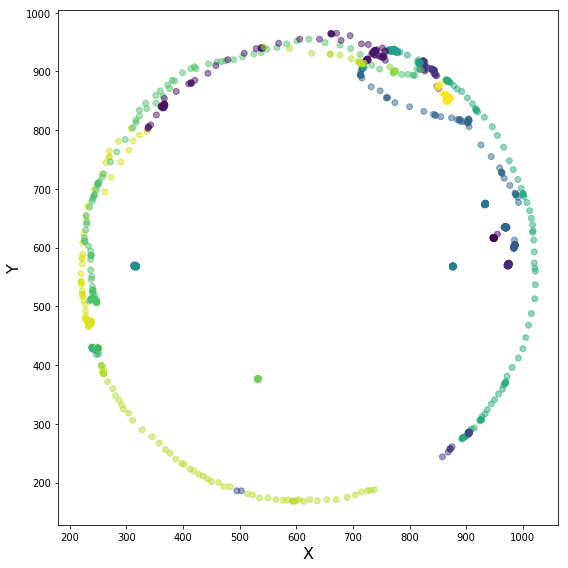

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
#plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], cmap='jet', alpha=0.5)
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], alpha=0.5)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig1.eps', format='eps', dpi=300)
plt.show()

In [ ]:
df_ord = df.groupby(['frame']).mean()
df_ord = df_ord.reset_index()

df_ord = df_ord.rename(index=str, columns={'pos_x':'centroid_x', 'pos_y':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y', 'speed':'gspeed'})

In [ ]:
df = pd.merge(df, df_ord, how='left')

In [ ]:
tmpx = (df['pos_x'] - df['centroid_x'])
tmpy = (df['pos_y'] - df['centroid_y'])
df['centroid_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['centroid_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

tmpx = (df['pos_x'] - mask.shape[1]//2 + mask_offset_x)
tmpy = (df['pos_x'] - mask.shape[0]//2 + mask_offset_y)
df['arena_centre_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['arena_centre_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

In [ ]:
centroid_disp = [df['centroid_disp_x'], df['centroid_disp_y']]
direction = [df['dir_x'], df['dir_y']]

arena_disp = [df['arena_centre_disp_x'], df['arena_centre_disp_y']]

In [ ]:
df['rotation'] = np.cross(np.array(centroid_disp).T, np.array(direction).T)
df['arena_rotation'] = np.cross(np.array(arena_disp).T, np.array(direction).T)

In [ ]:
df_ord = df.groupby(['frame']).agg(['sum', 'count'])
df_ord = df_ord.reset_index()

In [ ]:
df_ord['polarisation'] = np.sqrt(df_ord['dir_x']['sum']**2 + df_ord['dir_y']['sum']**2) / df_ord['dir_x']['count']
df_ord['rotation'] = df_ord['rotation']['sum'].divide(df_ord['rotation']['count'])
df_ord['arena_rotation'] = df_ord['arena_rotation']['sum'].divide(df_ord['arena_rotation']['count'])

In [ ]:
plt.figure(figsize=(30,3))
plt.plot(df_ord['frame']/30, df_ord['rotation']['sum'], color='r', label='Rotatioin (about group centroid)')
plt.plot(df_ord['frame']/30, df_ord['arena_rotation']['sum'], color='g', label='Rotation (about arena centre)') 
plt.plot(df_ord['frame']/30, df_ord['polarisation'], color='b', label='Polarisation')
plt.xlabel('Time (s)', fontsize=16)
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('imgs/ex4_fig2.eps', format='eps', dpi=300)
plt.show()

In [ ]:
import seaborn as sns

plot = sns.jointplot(df_ord['polarisation'], df_ord['rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plot.set_axis_labels('Polarisation', 'Rotation (about group centroid)', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig3a.eps', format='eps', dpi=300)
plt.show()

In [ ]:
plot = sns.jointplot(df_ord['polarisation'], df_ord['arena_rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plot.set_axis_labels('Polarisation', 'Rotation (about arena centre)', fontsize=16)
plt.tight_layout()
plt.savefig('imgs/ex4_fig3b.eps', format='eps', dpi=300)
plt.show()

In [ ]:
print(np.median(df_ord['polarisation']), np.median(np.abs(df_ord['rotation']['sum'])), np.median(np.abs(df_ord['arena_rotation']['sum'])))